Copyright 2025 The Institute of Cancer Research.

Licensed under a software academic use license provided with this software package (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at: https://github.com/CalumGabbutt/evoflux
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and limitations under the License.

# EVOFLUx - A method to infer the evolutionary history of a cancer from fluctuating methylation data

In this notebook, I demonstrate how to run the EVOFLUx method to infer the growth rate, time since the most recent common ancestor (MRCA) and the epigenetic switching rate of a cancer sample. I also demonstrate how a model selection approach allows for the detection of subclonal selection. 

First let's import the modules that we will use in this notebook:

In [1]:
import numpy as np
import pandas as pd
from evoflux import evoflux as ev
import evoflux.evoloo as el
import evoflux.evoplots as ep
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
datafile = 'data/beta_fcpgs.csv'
patientinfofile = 'data/BloodMethMetadata.csv'
outdir = 'examples'
sample = 'SCLL-059'
nlive = 100
NSIM = 2000
NCORES = 7

beta_values = pd.read_csv(datafile, index_col = 0)
patientinfo = pd.read_csv(patientinfofile, index_col = 0) 

y = beta_values[sample].dropna().values
T = patientinfo.loc[sample, 'AGE_SAMPLING']

rho = patientinfo.loc[sample, 'PURITY_TUMOR_CONSENSUS'] / 100

Smin = 10**2
Smax = 10**9
constants = [rho, T, Smin, Smax, NSIM] 

thetamean = 3
thetastd = 2
muscale = 0.05
gammascale = 0.05
scales = [thetamean, thetastd, muscale, gammascale]

Let's plot the data, to check it follows our "w-shape" prediction:

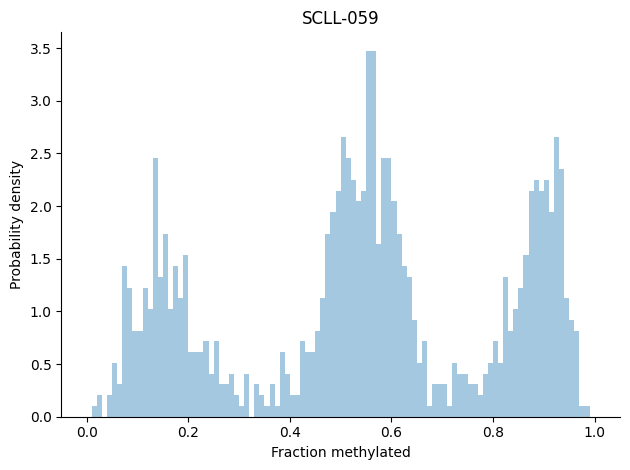

In [3]:
fig, ax = plt.subplots()      
plt.hist(y, np.linspace(0, 1, 101), density=True, 
alpha=0.4, linewidth=0) 
plt.xlabel("Fraction methylated")
plt.ylabel("Probability density")
plt.title(sample)
plt.tight_layout()
sns.despine()

Excellent, now let's run EVOFLUx! 

EVOFLUx can be time consuming to run, the neutral inference takes ~1hr on an 8 core machine. To alleviate this, an example EVOFLUx fit has been included. If you want to run the fit yourself, change the "overwrite" to True.

In [4]:
overwrite = False
mode = 'neutral'
outputdir = os.path.join(outdir, mode)
sample_meth = 'unif' if mode == 'neutral' else 'rwalk'
verbose = True
dlogz = 0.5

outsamplesdir = os.path.join(outputdir, sample)
outsamples = os.path.join(outsamplesdir, f'{sample}_posterior.pkl')

os.makedirs(outsamplesdir, exist_ok=True)

if overwrite:
    res = ev.run_inference(y, 
                            T, 
                            outsamples,
                            rho=rho,
                            Smin=Smin,
                            Smax=Smax,
                            nlive=nlive, 
                            NSIM=NSIM,
                            verbose=verbose,
                            dlogz=dlogz, 
                            mode=mode,
                            sample_meth=sample_meth,
                            Ncores=NCORES)
    
    df = ev.extract_posterior(res, mode, outsamplesdir, 
                              sample, overwrite=overwrite)
else:
    with open(outsamples, 'rb') as f:
        res = joblib.load(f)

    df = ev.extract_posterior(res, mode, outsamplesdir, sample)
    labels = df.columns.to_list()

We shall plots the trace of the nested sampler to show how the sampler "zooms in" on the typical set across the course of sampling, using the inbuilt dynesty sampler.

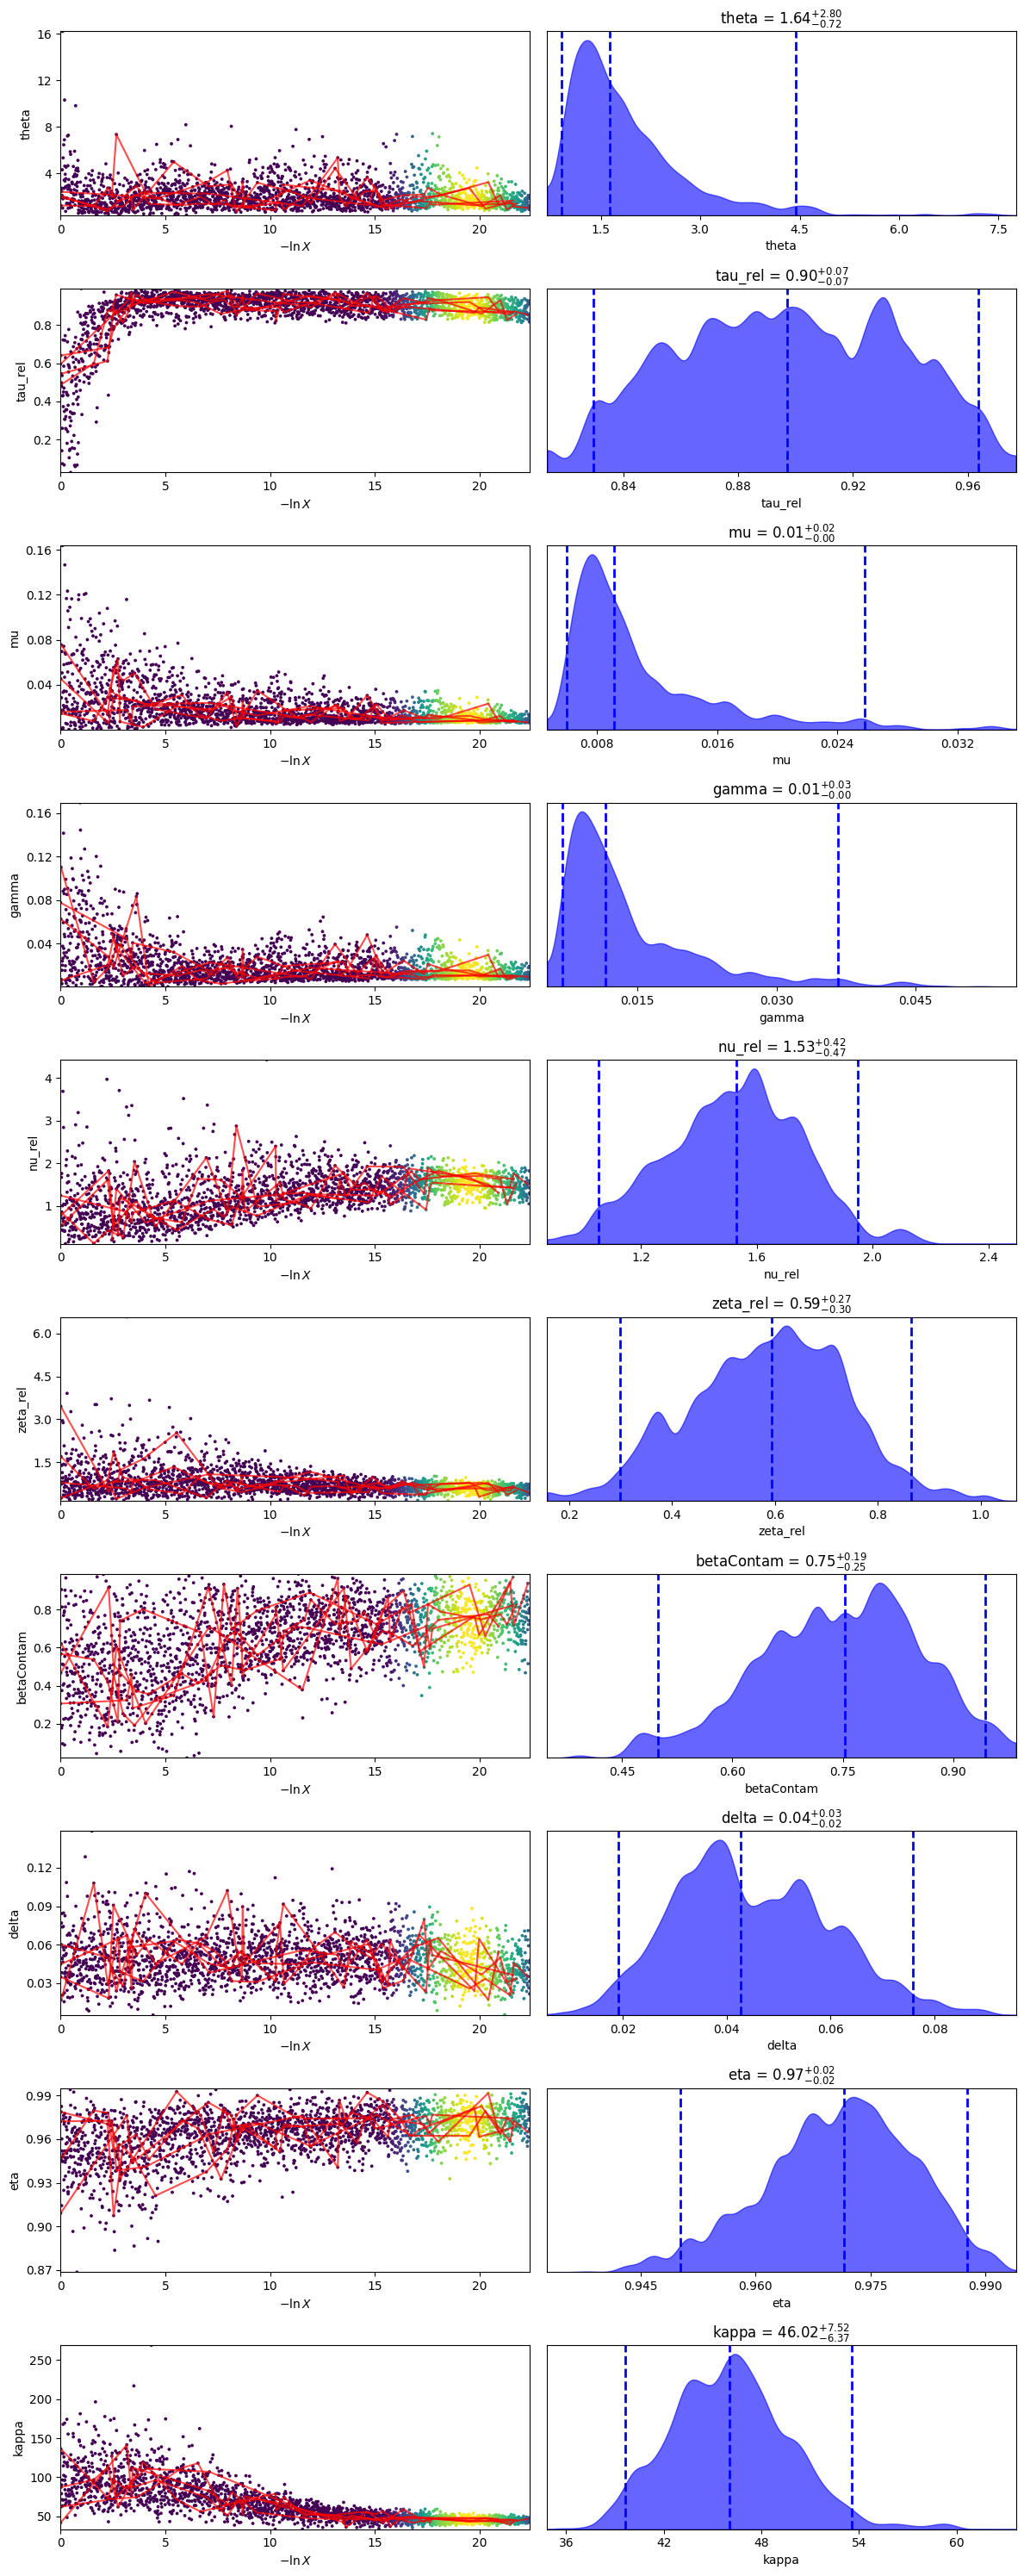

In [5]:
ep.plot_trace(res, outsamplesdir, sample, labels, save = False)

Using the inbuilt dynesty plotting function, let's plot the pairwise marginal distributions of the inferred variables

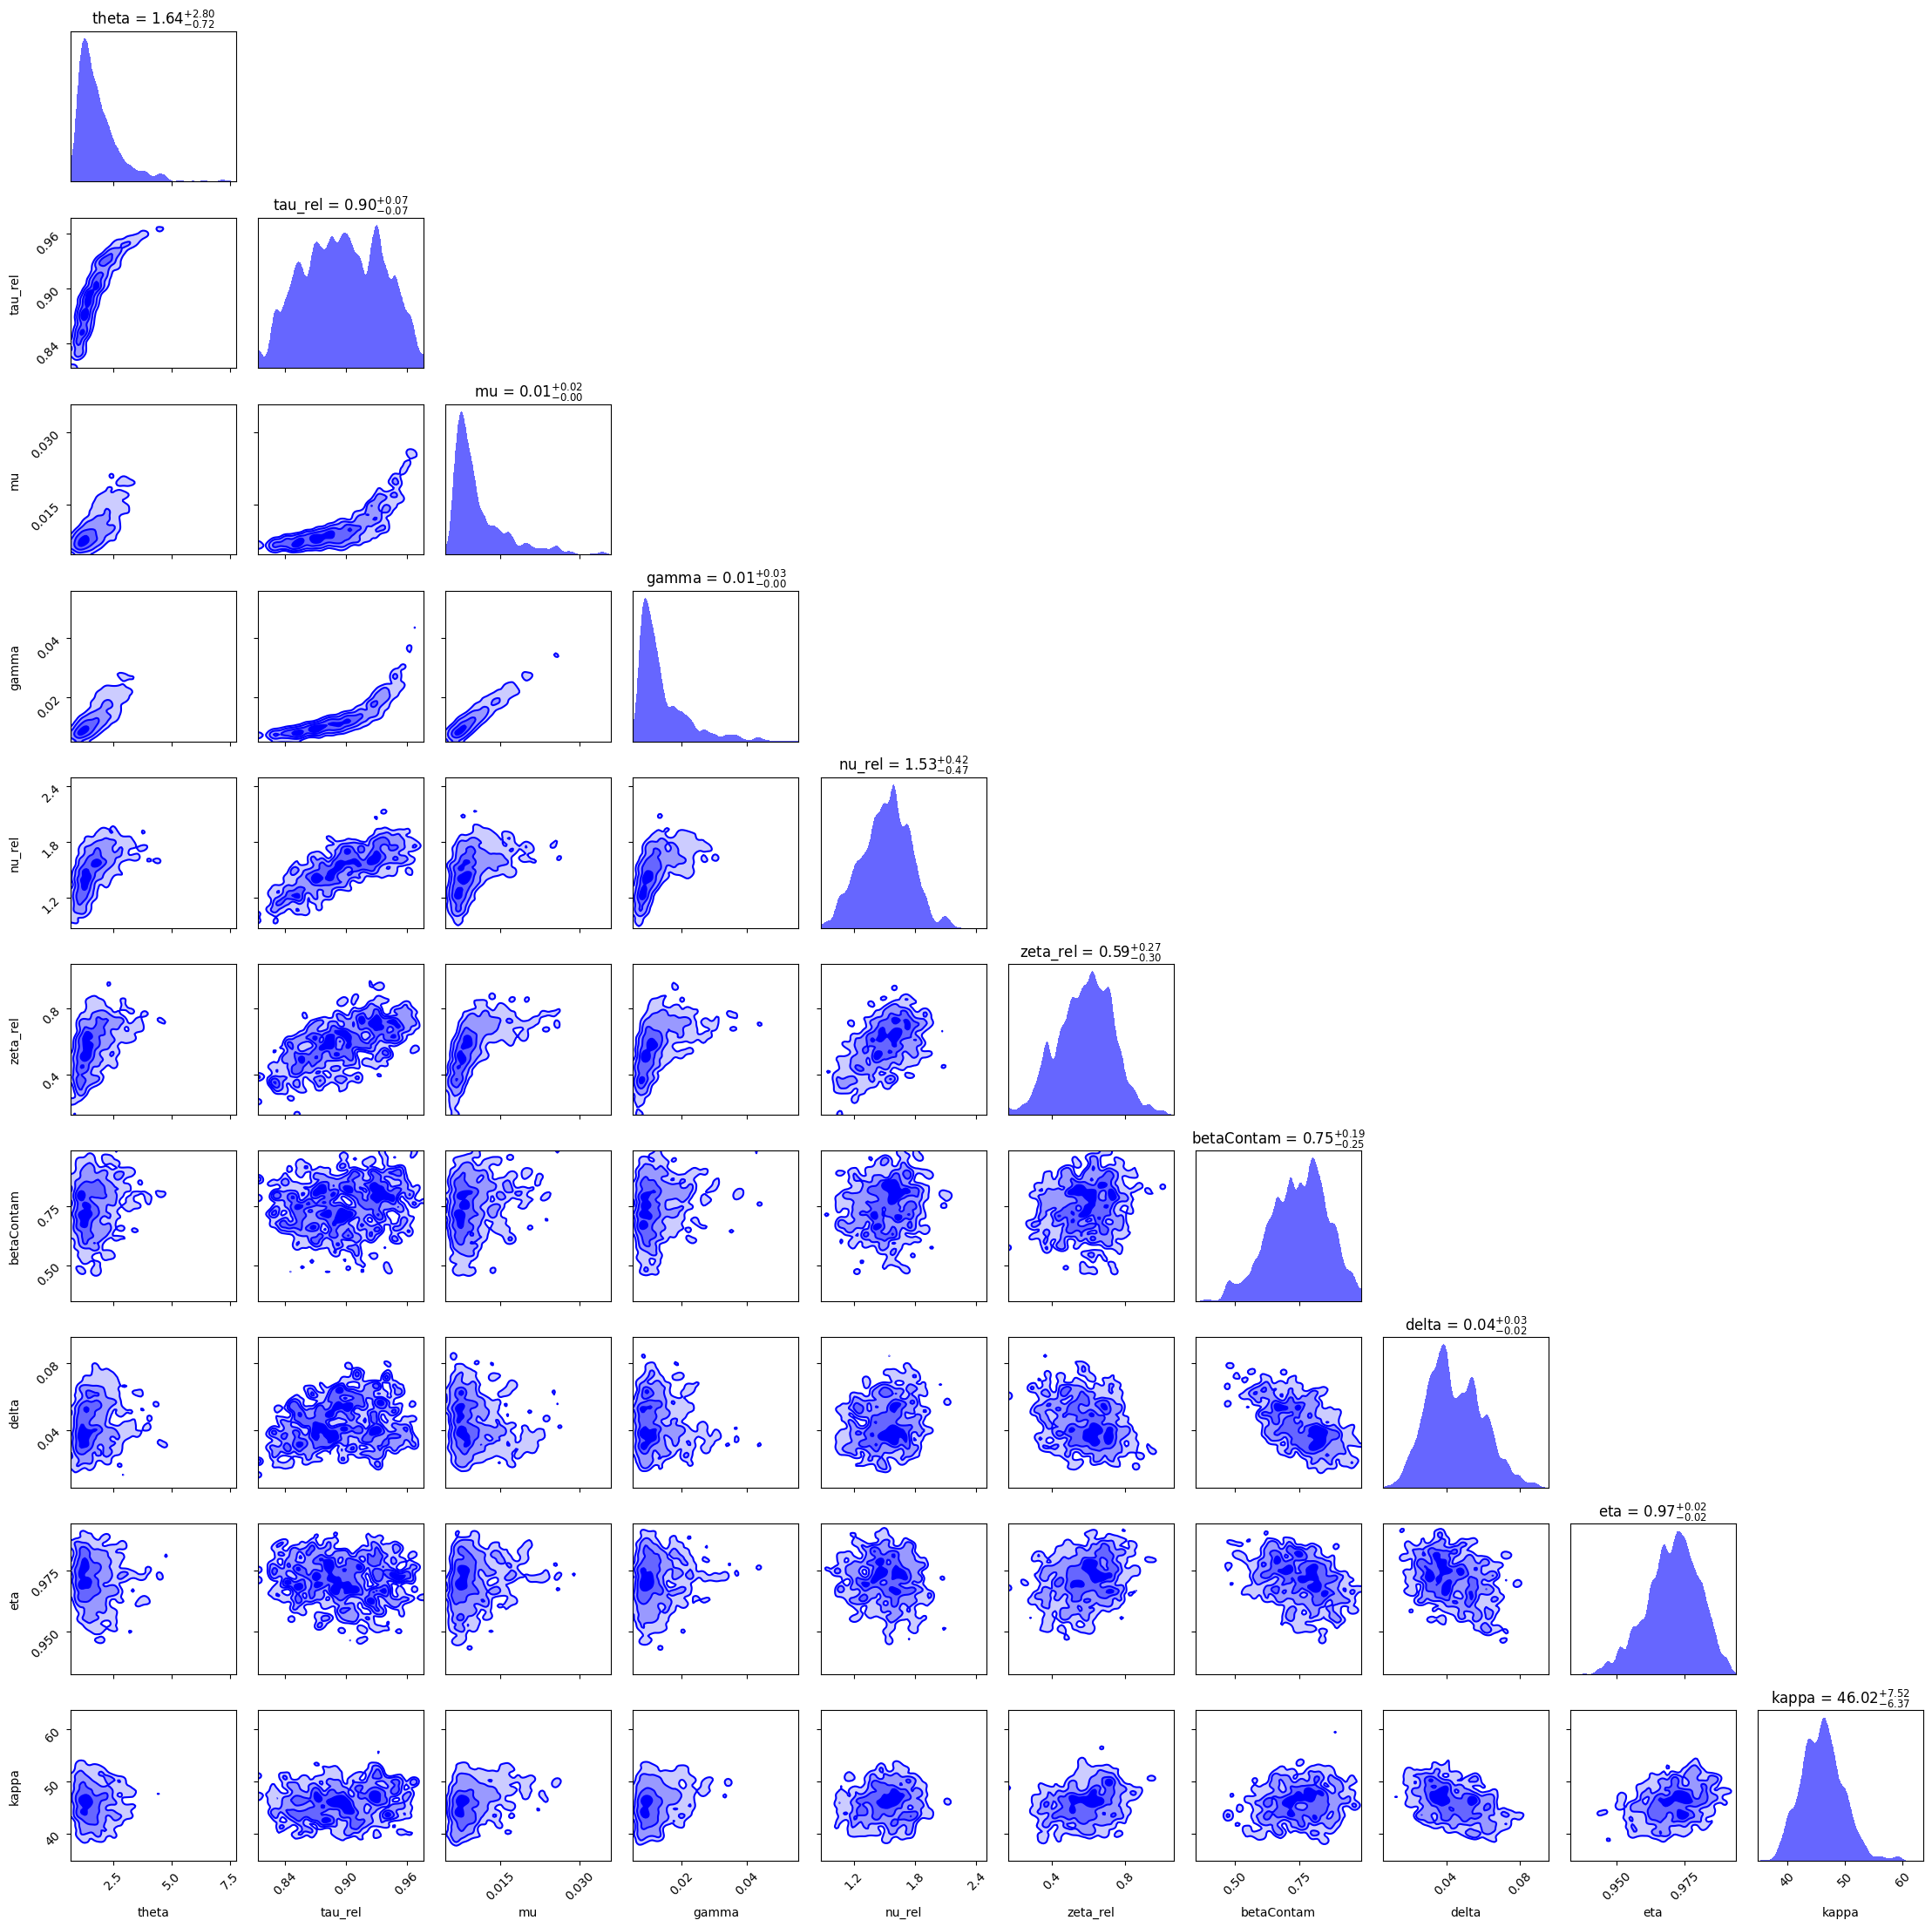

In [6]:
ep.plot_cornerplot(res, outsamplesdir, sample, labels, save = False)

And using the "corner" package.

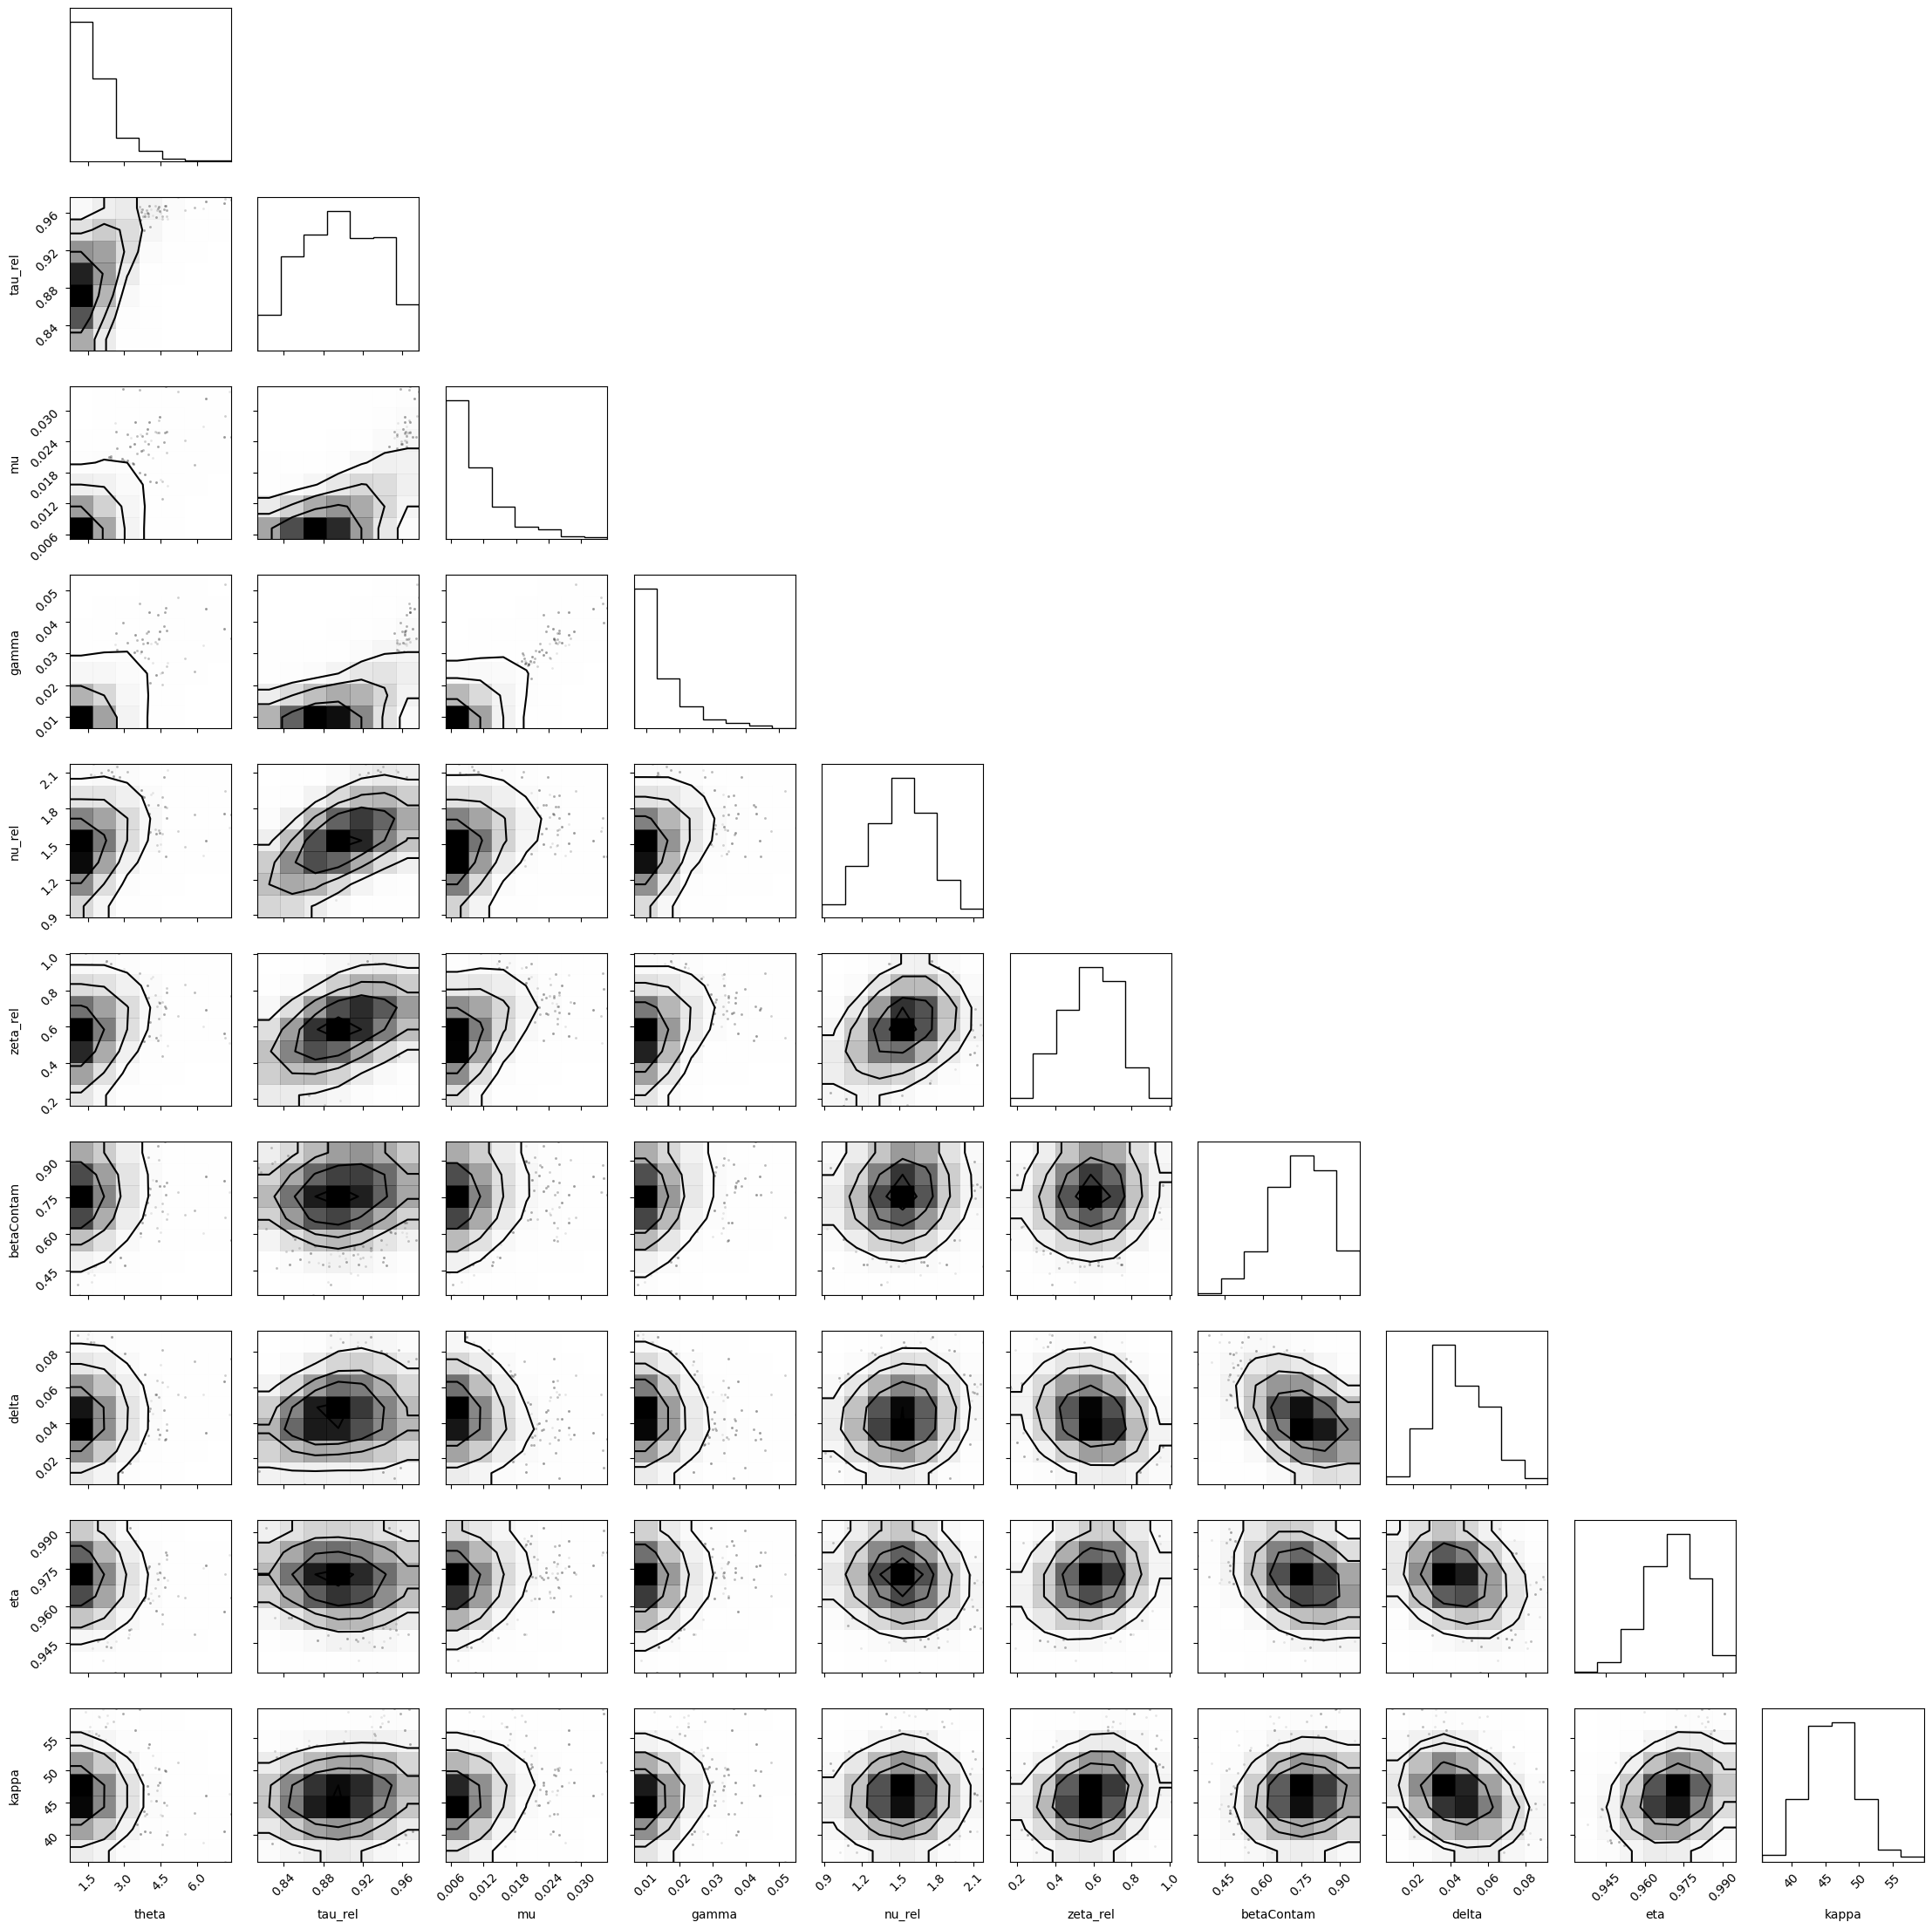

In [7]:
ep.plot_corner(df, outsamplesdir, sample, save = False)

Now let's plot the posterior predictive distribution (i.e. the model fit)

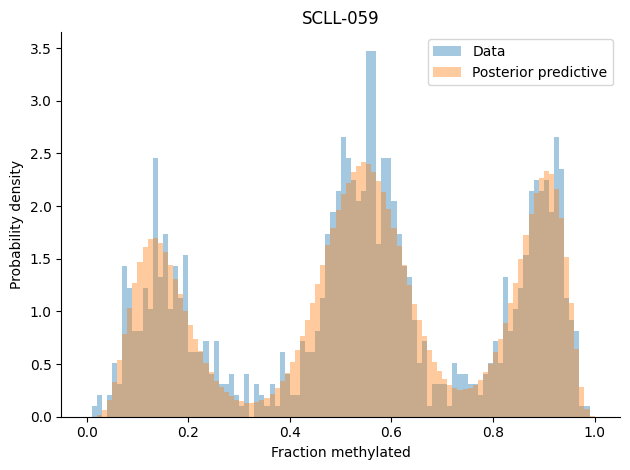

In [8]:
ep.plot_posterior_predictive(y, df, constants, mode, outsamplesdir, sample, NCORES, save = False)

And finally, let's overlay the inferred posterior distributions with the priors, to show how well the data informs the parameters

/Users/cgabbutt/Github/evoflux_example/evoflux/evolfuxenv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


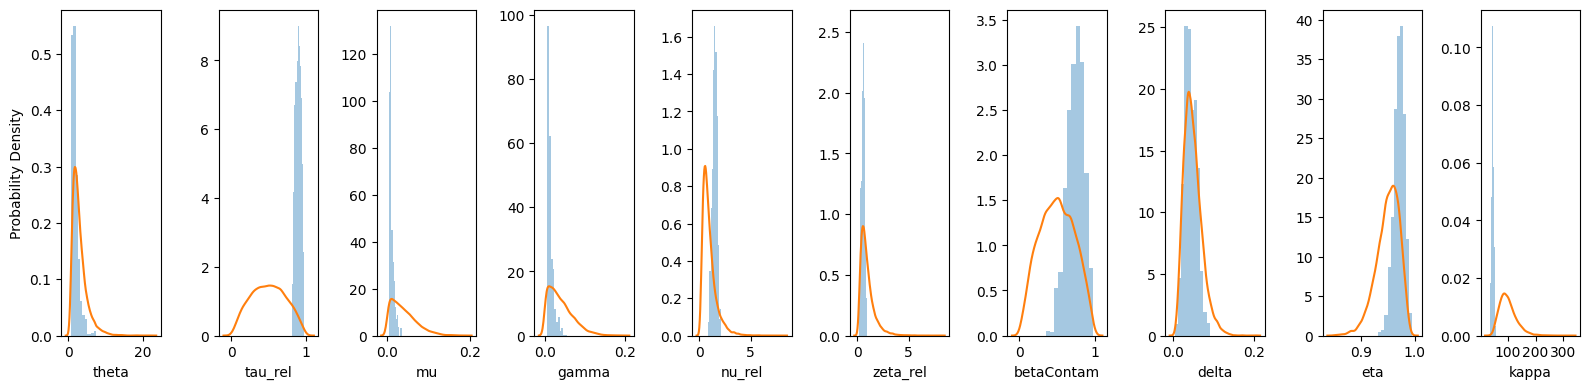

In [9]:
ep.plot_prior_shrinkage(df, scales, mode, outsamplesdir, sample, save = False)

To perform model selection, we need to calculate the loglikelihood per datapoint for every point in the posterior, and to reduce the stochastic noise in the synthetic likelihood calculation, we should use a high $n_{sim}$. This is the other time consuming step, so to reduce the computational burden of running the calculation again, the likelihood calculation is included (if overwrite=True above, this will be recalculated).

In [10]:
inference_neutral = el.calculate_loo(y, T, outsamplesdir, sample,
                            rho=rho, Smin=Smin, Smax=Smax,
                            NSIM=NSIM, mode=mode, 
                            Ncores = NCORES, overwrite=overwrite)

Log-likelihood file already exists


Along a similar line, the subclonal inference has already been run - load that here

In [12]:
subclonal_dir = f'examples/subclonal/{sample}'
inference_subclonal = el.calculate_loo(y, T, subclonal_dir, sample,
                            rho=rho, Smin=Smin, Smax=Smax,
                            NSIM=NSIM, mode='subclonal', 
                            Ncores = NCORES)

Log-likelihood file already exists


In [13]:
inference_list = [inference_neutral, inference_subclonal]
labels = ['Neutral', 'Subclonal']


Use leave-one-out (loo) to compare the models, as described in: [Vehtari, A., et al. (2017)](https://doi.org/10.1007/s11222-016-9696-4) and [Yao, Y., et al. (2018)](https://doi.org/10.1214/17-BA1091)

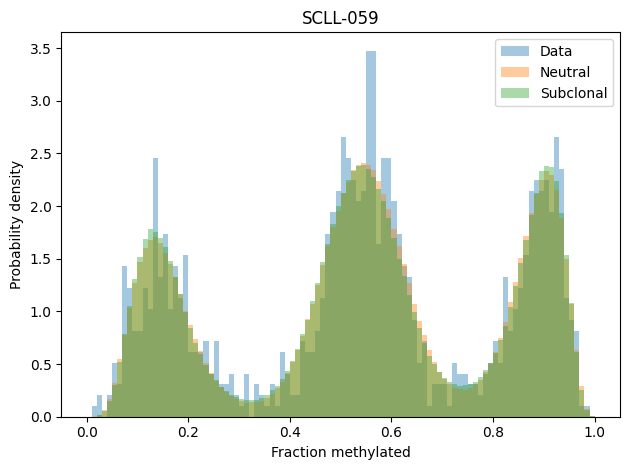

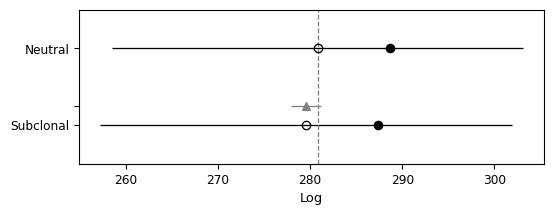

In [14]:
model_compare = el.model_selection(inference_list, outputdir, sample, labels, save = False)

In [15]:
model_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Neutral,0,280.815235,7.815806,0.000000,0.713883,22.260869,0.000000,False,log
Subclonal,1,279.564008,7.810264,1.251228,0.286117,22.360605,1.613482,False,log


The fits of the Neutral and Subclonal model are very similar, so the loo weakly prefers the Neutral model